# AlexNet Model Implementation

Based on the following paper: [ImageNet Classification with Deep Convolutional
Neural Networks](https://papers.nips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

### Implementation Detail:
The implementation made in this program follows the original paper closely but added the following modern techniques:
1. Adam optimizer
2. Kaiming Initialization (implicitly, pytorch uses kaiming_uniform as default initializer for a lot of layer types, including convolutional layer)

### Architecture
**Backbone**
1. Convolutional Layer (Conv2d -> Leaky ReLU -> BatchNorm2d)
2. Convolutional Layer
3. Convolutional Layer

**Head**  
4. Fully Connected ( Linear -> Leaky ReLU -> Dropout)  
5. Fully Connected (Linear -> Leaky ReLU -> Dropout)

### Dataset

Uses Imagenette (a smaller subset of The ImageNet dataset) available from [fastai](https://github.com/fastai/imagenette) or [pytorch](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html)  
Imagenette consists of images with the following class label
```
        "n01440764": ("tench", "Tinca tinca"),
        "n02102040": ("English springer", "English springer spaniel"),
        "n02979186": ("cassette player",),
        "n03000684": ("chain saw", "chainsaw"),
        "n03028079": ("church", "church building"),
        "n03394916": ("French horn", "horn"),
        "n03417042": ("garbage truck", "dustcart"),
        "n03425413": ("gas pump", "gasoline pump", "petrol pump", "island dispenser"),
        "n03445777": ("golf ball",),
        "n03888257": ("parachute", "chute"),
```

## Code

## Loading Libraries

In [1]:
# Top level package
import torch
import torchvision

# Image augmentation operations
from torchvision.transforms import v2

# NN-layers
from torch import nn

# Activation functions
import torch.nn.functional as F

# Optimizers
import torch.optim as optim

# Data reader and loader
from torch.utils.data import TensorDataset, DataLoader, Subset

# Evaluation suite
import torchmetrics

# Imagenette utils
from torchvision.datasets import Imagenette

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# numpy
import numpy as np

# pandas
import pandas as pd

# sklearn for stratified split
from sklearn.model_selection import train_test_split

# setting random seed for replicability
torch.manual_seed(42)

## Loading & Reading Dataset

### Defining Image Augmentations

In [2]:
# autoaugment policy from https://arxiv.org/abs/1805.09501 
# https://pytorch.org/vision/main/generated/torchvision.transforms.v2.AutoAugment.html

# policy = v2.AutoAugmentPolicy.IMAGENET

# resize to 224 x 224 -> autoaugment -> turn to tensor
# custom_transforms = v2.Compose([
#     v2.Resize(size=(224, 224)),
#     v2.AutoAugment(policy=policy),
#     v2.ToImage(),
#     v2.ToDtype(torch.float32, scale=True)
# ])

# simple rotation and contrast transform
custom_transforms = v2.Compose([
    v2.Resize(size = (227,227)),
    v2.RandomHorizontalFlip(p = 0.5),
    v2.RandomVerticalFlip(p = 0.5),
    v2.RandomAutocontrast(p = 0.5),
    v2.ToTensor()
])

convert_to_tensor = v2.Compose([
    v2.Resize(size=(227, 227)),
    # v2.ToImage(),
    # v2.ToDtype(torch.float32, scale=True)
    v2.ToTensor()
])

E:\Current_Workdir\Portfolios\CNN-on-Imagenette\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


### Loading Training and Testing Data

In [3]:
train_filepath = "../dataset/imagenette2/train"
test_filepath = "../dataset/imagenette2/val"

In [4]:
# imagenette_train = Imagenette(filepath, split="train", transform=custom_transforms, download=False)
# imagenette_test = Imagenette(filepath, split="val", transform=convert_to_tensor, download=False)

imagenette_train = torchvision.datasets.ImageFolder(train_filepath, transform= custom_transforms)
imagenette_test = torchvision.datasets.ImageFolder(test_filepath, transform=convert_to_tensor)

### Creating Training/Validation/Testing Split

In [5]:
train_idx, val_idx, _, _ = train_test_split(
    range(len(imagenette_train)),
    imagenette_train.targets,
    stratify=imagenette_train.targets,
    test_size=0.1,
    random_state=42
)

In [6]:
train_idx[:10]

[1692, 7661, 450, 3139, 3622, 5081, 6477, 5995, 6702, 2775]

In [7]:
min(val_idx)

1

In [8]:
imagenette_train = Subset(imagenette_train, train_idx)
imagenette_valid = Subset(imagenette_train, val_idx)

In [9]:
imagenette_valid.dataset

### Creating Data Loader

In [10]:
batch_size = 64

In [11]:
train_dataloader = DataLoader(imagenette_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(imagenette_valid.dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(imagenette_test, batch_size=batch_size, shuffle=True)

In [12]:
val_dataloader

### Inspecting Sample Data

In [13]:
label_dict = {
    0: "tench",
    1: "English springer",
    2: "cassette player",
    3: "chain saw",
    4: "church",
    5: "French horn",
    6: "garbage truck",
    7: "gas pump",
    8: "golf ball",
    9: "parachute"
}

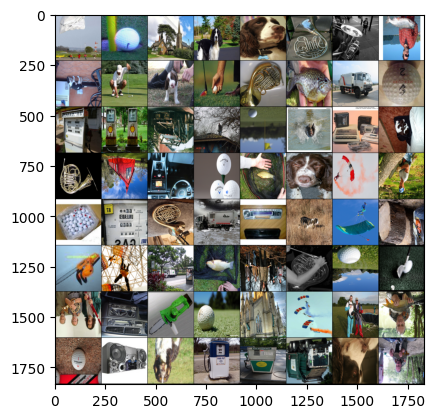

['parachute', 'golf ball', 'church', 'English springer', 'English springer', 'French horn', 'French horn', 'tench', 'English springer', 'golf ball', 'English springer', 'golf ball', 'French horn', 'tench', 'garbage truck', 'golf ball', 'gas pump', 'gas pump', 'garbage truck', 'chain saw', 'golf ball', 'English springer', 'cassette player', 'English springer', 'French horn', 'church', 'cassette player', 'golf ball', 'tench', 'English springer', 'parachute', 'chain saw', 'golf ball', 'gas pump', 'French horn', 'garbage truck', 'cassette player', 'English springer', 'parachute', 'chain saw', 'chain saw', 'parachute', 'garbage truck', 'tench', 'chain saw', 'French horn', 'golf ball', 'golf ball', 'French horn', 'cassette player', 'chain saw', 'golf ball', 'church', 'parachute', 'parachute', 'tench', 'golf ball', 'cassette player', 'English springer', 'gas pump', 'gas pump', 'garbage truck', 'English springer', 'tench']


In [14]:
# Training Data
# get some random training images
train_dataiter = iter(train_dataloader)
train_images, train_labels = next(train_dataiter)

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(train_images))
# print labels
print([label_dict[train_labels[j].item()] for j in range(batch_size)])

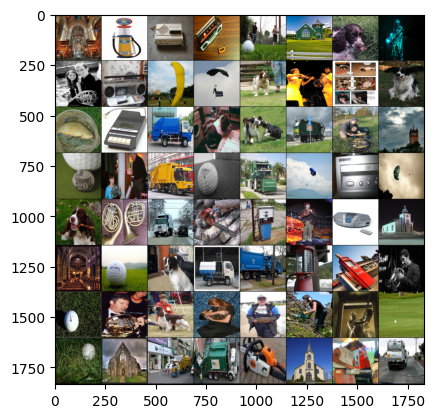

['church', 'gas pump', 'cassette player', 'cassette player', 'golf ball', 'church', 'English springer', 'French horn', 'French horn', 'cassette player', 'parachute', 'parachute', 'English springer', 'French horn', 'English springer', 'English springer', 'tench', 'cassette player', 'garbage truck', 'English springer', 'English springer', 'garbage truck', 'tench', 'church', 'golf ball', 'French horn', 'garbage truck', 'golf ball', 'garbage truck', 'parachute', 'cassette player', 'parachute', 'English springer', 'French horn', 'garbage truck', 'chain saw', 'gas pump', 'French horn', 'cassette player', 'church', 'church', 'golf ball', 'English springer', 'garbage truck', 'garbage truck', 'gas pump', 'gas pump', 'French horn', 'golf ball', 'French horn', 'English springer', 'French horn', 'tench', 'chain saw', 'chain saw', 'golf ball', 'golf ball', 'church', 'garbage truck', 'garbage truck', 'chain saw', 'church', 'chain saw', 'garbage truck']


In [15]:
# Testing Data
# get some random testing images
test_dataiter = iter(test_dataloader)
test_images, test_labels = next(test_dataiter)

# show images
imshow(torchvision.utils.make_grid(test_images))
# print labels
print([label_dict[test_labels[j].item()] for j in range(batch_size)])

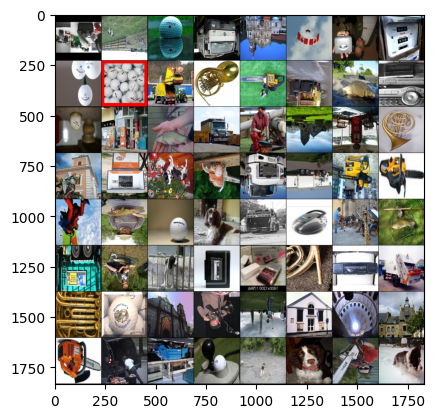

['cassette player', 'English springer', 'golf ball', 'garbage truck', 'church', 'parachute', 'cassette player', 'gas pump', 'golf ball', 'golf ball', 'garbage truck', 'French horn', 'chain saw', 'garbage truck', 'tench', 'cassette player', 'golf ball', 'gas pump', 'tench', 'garbage truck', 'chain saw', 'church', 'gas pump', 'French horn', 'church', 'gas pump', 'English springer', 'chain saw', 'garbage truck', 'garbage truck', 'chain saw', 'chain saw', 'parachute', 'tench', 'golf ball', 'English springer', 'garbage truck', 'cassette player', 'French horn', 'tench', 'garbage truck', 'tench', 'English springer', 'cassette player', 'cassette player', 'French horn', 'cassette player', 'garbage truck', 'French horn', 'golf ball', 'church', 'French horn', 'golf ball', 'church', 'church', 'church', 'chain saw', 'garbage truck', 'garbage truck', 'golf ball', 'English springer', 'English springer', 'chain saw', 'English springer']


In [16]:
# validation Data
# get some random validation images
val_dataiter = iter(val_dataloader)
val_images, val_labels = next(val_dataiter)

# show images
imshow(torchvision.utils.make_grid(val_images))
# print labels
print([label_dict[val_labels[j].item()] for j in range(batch_size)])

## Defining Model

### Model Architecture

In [17]:
# Model architecture
class AlexNet(nn.Module):
    def __init__(self, num_target_class):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            # first convolutional block
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            
            # second convolutional block
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            
            # third convolutional block
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_target_class),
        )
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [18]:
 # Instantiating the model
net = AlexNet(num_target_class=10)
net

AlexNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(

### Loss Function

In [19]:
loss_function = nn.CrossEntropyLoss()
loss_function

CrossEntropyLoss()

### Optimizer

In [20]:
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

### Configuring Device (GPU / CPU)

In [21]:
# use GPU if available, if not then use CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Metric

In [22]:
# define eval metrics
# multiclass accuracy top-1
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10, top_k = 1)
metric.to(device)

MulticlassAccuracy()

## Training

### Loading Model to Device

In [23]:
net.to(device)

AlexNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(

### Training Loop

In [24]:
# specify number of epoch
num_epoch = 10

In [25]:
train_loss = []
val_loss = []
val_acc = []

In [26]:
for epoch in range(num_epoch):
    
    net.train()
    for data in train_dataloader:
        # move data to device
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the gradient parameters
        optimizer.zero_grad()
        
        # forward propagation
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        
        # backward propagation
        loss.backward()
        optimizer.step()

    # save training loss for visualization
    train_loss.append(loss.item())
    print('Epoch [{}/{}] Training, Loss: {:.4f}'.format(epoch+1, num_epoch, loss.item()))

    # calculating validation loss & accuracy
    net.eval()
    for data in val_dataloader:
        # move validation data to device
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # get prediction
        predictions = net(inputs)
        
        # compute validation accuraccy
        acc = metric(labels, predictions.argmax(dim=-1))
        
        # compute validation loss
        loss = loss_function(predictions, labels)
    
    # save validation loss for visualization
    accuracy = metric.compute()
    val_loss.append(loss.item())
    val_acc.append(accuracy.item())
    print('Epoch [{}/{}] Validation, Loss: {:.4f}, Acc : {:.4f}'.format(epoch+1, num_epoch, loss.item(), accuracy))
        
print('Training Loop Finished')

Epoch [1/10] Training, Loss: 1.9062
Epoch [1/10] Validation, Loss: 2.2271, Acc : 0.2793
Epoch [2/10] Training, Loss: 1.8772
Epoch [2/10] Validation, Loss: 2.0746, Acc : 0.2406
Epoch [3/10] Training, Loss: 1.7026
Epoch [3/10] Validation, Loss: 2.1680, Acc : 0.2496
Epoch [4/10] Training, Loss: 1.7311
Epoch [4/10] Validation, Loss: 1.7915, Acc : 0.2640
Epoch [5/10] Training, Loss: 1.7495
Epoch [5/10] Validation, Loss: 1.6236, Acc : 0.2719
Epoch [6/10] Training, Loss: 2.0271
Epoch [6/10] Validation, Loss: 1.6575, Acc : 0.2900
Epoch [7/10] Training, Loss: 1.7632
Epoch [7/10] Validation, Loss: 1.6426, Acc : 0.3043
Epoch [8/10] Training, Loss: 2.5569
Epoch [8/10] Validation, Loss: 1.6139, Acc : 0.3179
Epoch [9/10] Training, Loss: 1.9074
Epoch [9/10] Validation, Loss: 1.2027, Acc : 0.3336
Epoch [10/10] Training, Loss: 1.4717
Epoch [10/10] Validation, Loss: 1.4277, Acc : 0.3514
Training Loop Finished


### Visualizing Loss and Accuracy

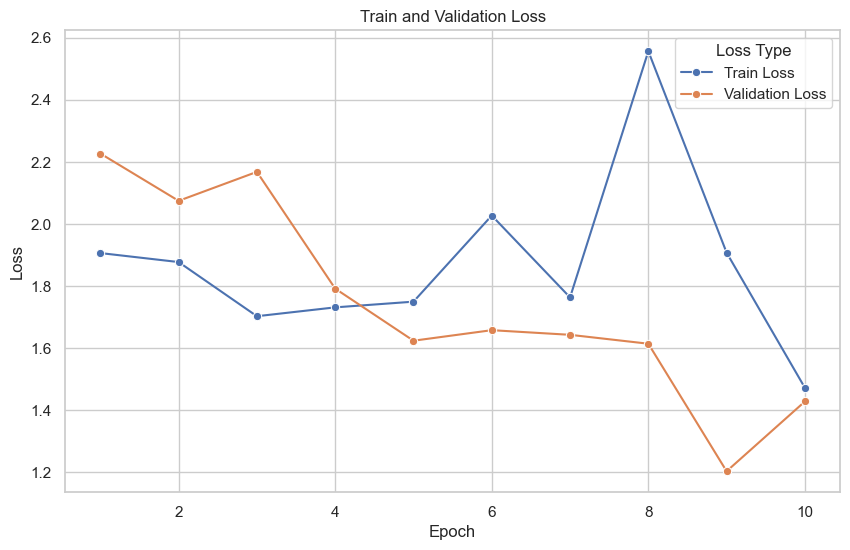

In [27]:
# Plotting Validation and Training Loss 
data = pd.DataFrame({'Epoch': range(1, len(train_loss) + 1),
                     'Train Loss': train_loss,
                     'Validation Loss': val_loss})

data_melted = pd.melt(data, id_vars=['Epoch'], var_name='Loss Type', value_name='Loss')

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='Loss', hue='Loss Type', data=data_melted, marker='o')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Loss Type')
plt.show()

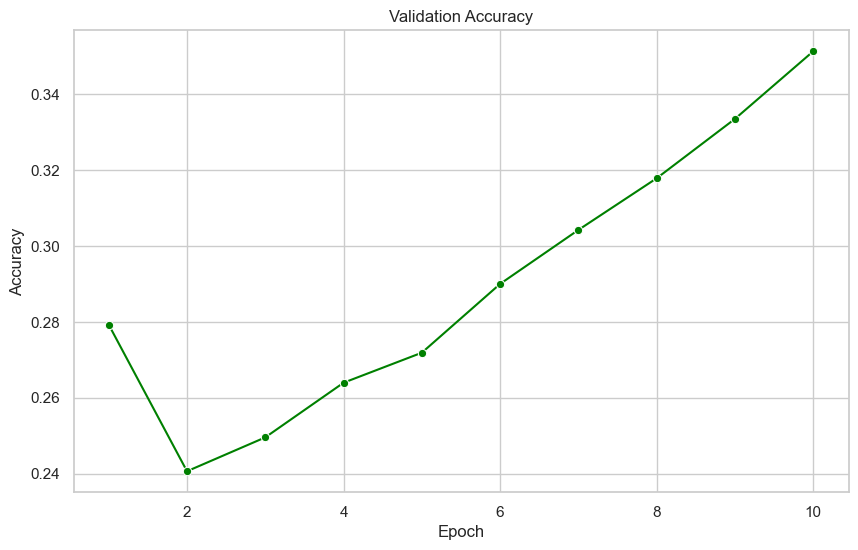

In [28]:
# Plotting Validation Accuracy
data_acc = pd.DataFrame({'Epoch': range(1, len(val_acc) + 1),
                         'Validation Accuracy': val_acc})

plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='Validation Accuracy', data=data_acc, marker='o', color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [29]:
PATH = r".\alexnet_imagenette.pth"
torch.save(net.state_dict(), PATH)

## Testing Loop

In [30]:
net.eval()
    
for i, data in enumerate(test_dataloader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)
    predictions = net(inputs)
    accuracy = metric(labels, predictions.argmax(dim=-1))
    
accuracy = metric.compute()
print(f"Accuracy on test data: {accuracy}")

Accuracy on test data: 0.35779908299446106
